In [ ]:
# pip install -r requirements.txt
# conda install libgl


In [7]:
from options import Options
from grid import Grid
from trajectory_generator import generate_trajectory
import torch
import numpy as np
import plotting
import analysis
import os
%load_ext autoreload
import utils
import matplotlib.pyplot as plt
from train_RNN import TrainableNetwork, RNN_options, Trainer
%autoreload 2
from scipy.linalg import null_space
from tqdm import tqdm

SIM_PATH = os.getcwd() + '/sim_data/'

EXAMPLE_PATH = os.getcwd() + "/example_models/"  # Put interesting RNN of interest here
if not os.path.exists(EXAMPLE_PATH):
    os.mkdir(EXAMPLE_PATH)

FIG_PATH = os.getcwd() + '/figures/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Build and intiialize network

In [6]:
options = Options(lambda_net =  17)
options.dt= 5E-4
# options.n=128 # warning : large memory usage
options.n = 100
options.alpha=0.1

options.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device :', options.device)
grid = Grid(options)

device : cuda
Recovering pre-computed matrix found at /home/onyxia/work/grid_cells_burak_fiete/models/Wmat_beta=0.010380622837370242_gamma=0.011937716262975778_periodic=True_a=1.5_l=2_n=100.pth
Restoring pre-computed initial state found at /home/onyxia/work/grid_cells_burak_fiete/models/s0_beta=0.010380622837370242_gamma=0.011937716262975778_periodic=True_a=1.5_l=2_n=100_tau=0.01_alpha=0.1_tiling=deterministic_device=cuda_solver=euler_dt=0.0005.pth


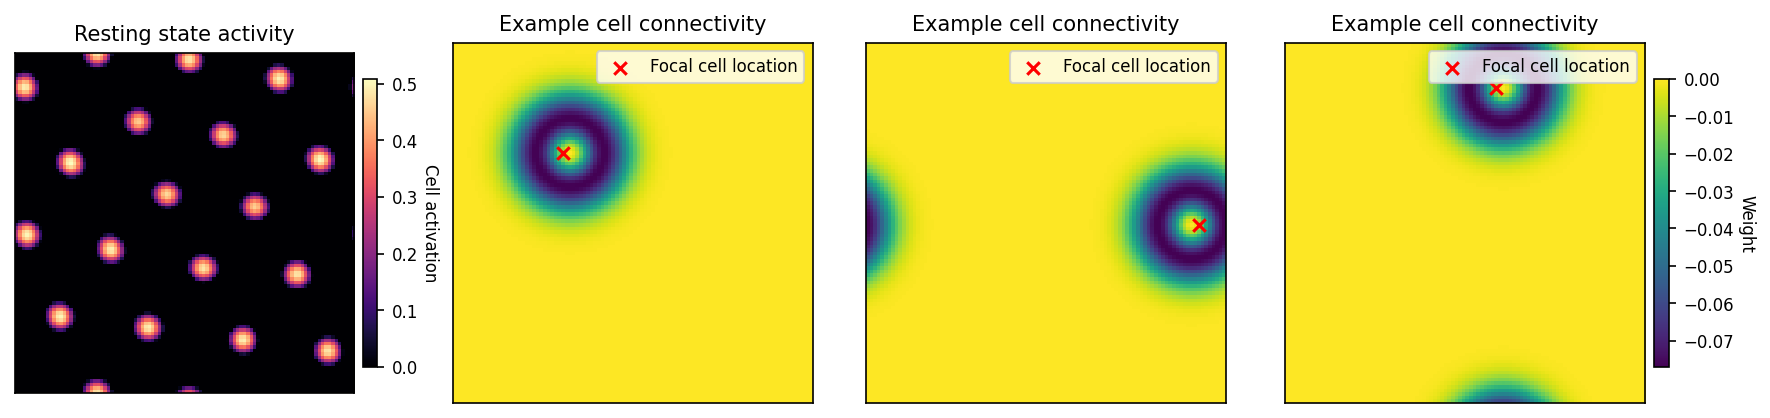

In [4]:
plotting.network_presentation(grid, show=False)
plt.savefig(FIG_PATH+"network_presentation.png", transparent=True)

Simulating with Euler method


100%|██████████| 199/199 [00:00<00:00, 595.99it/s] 


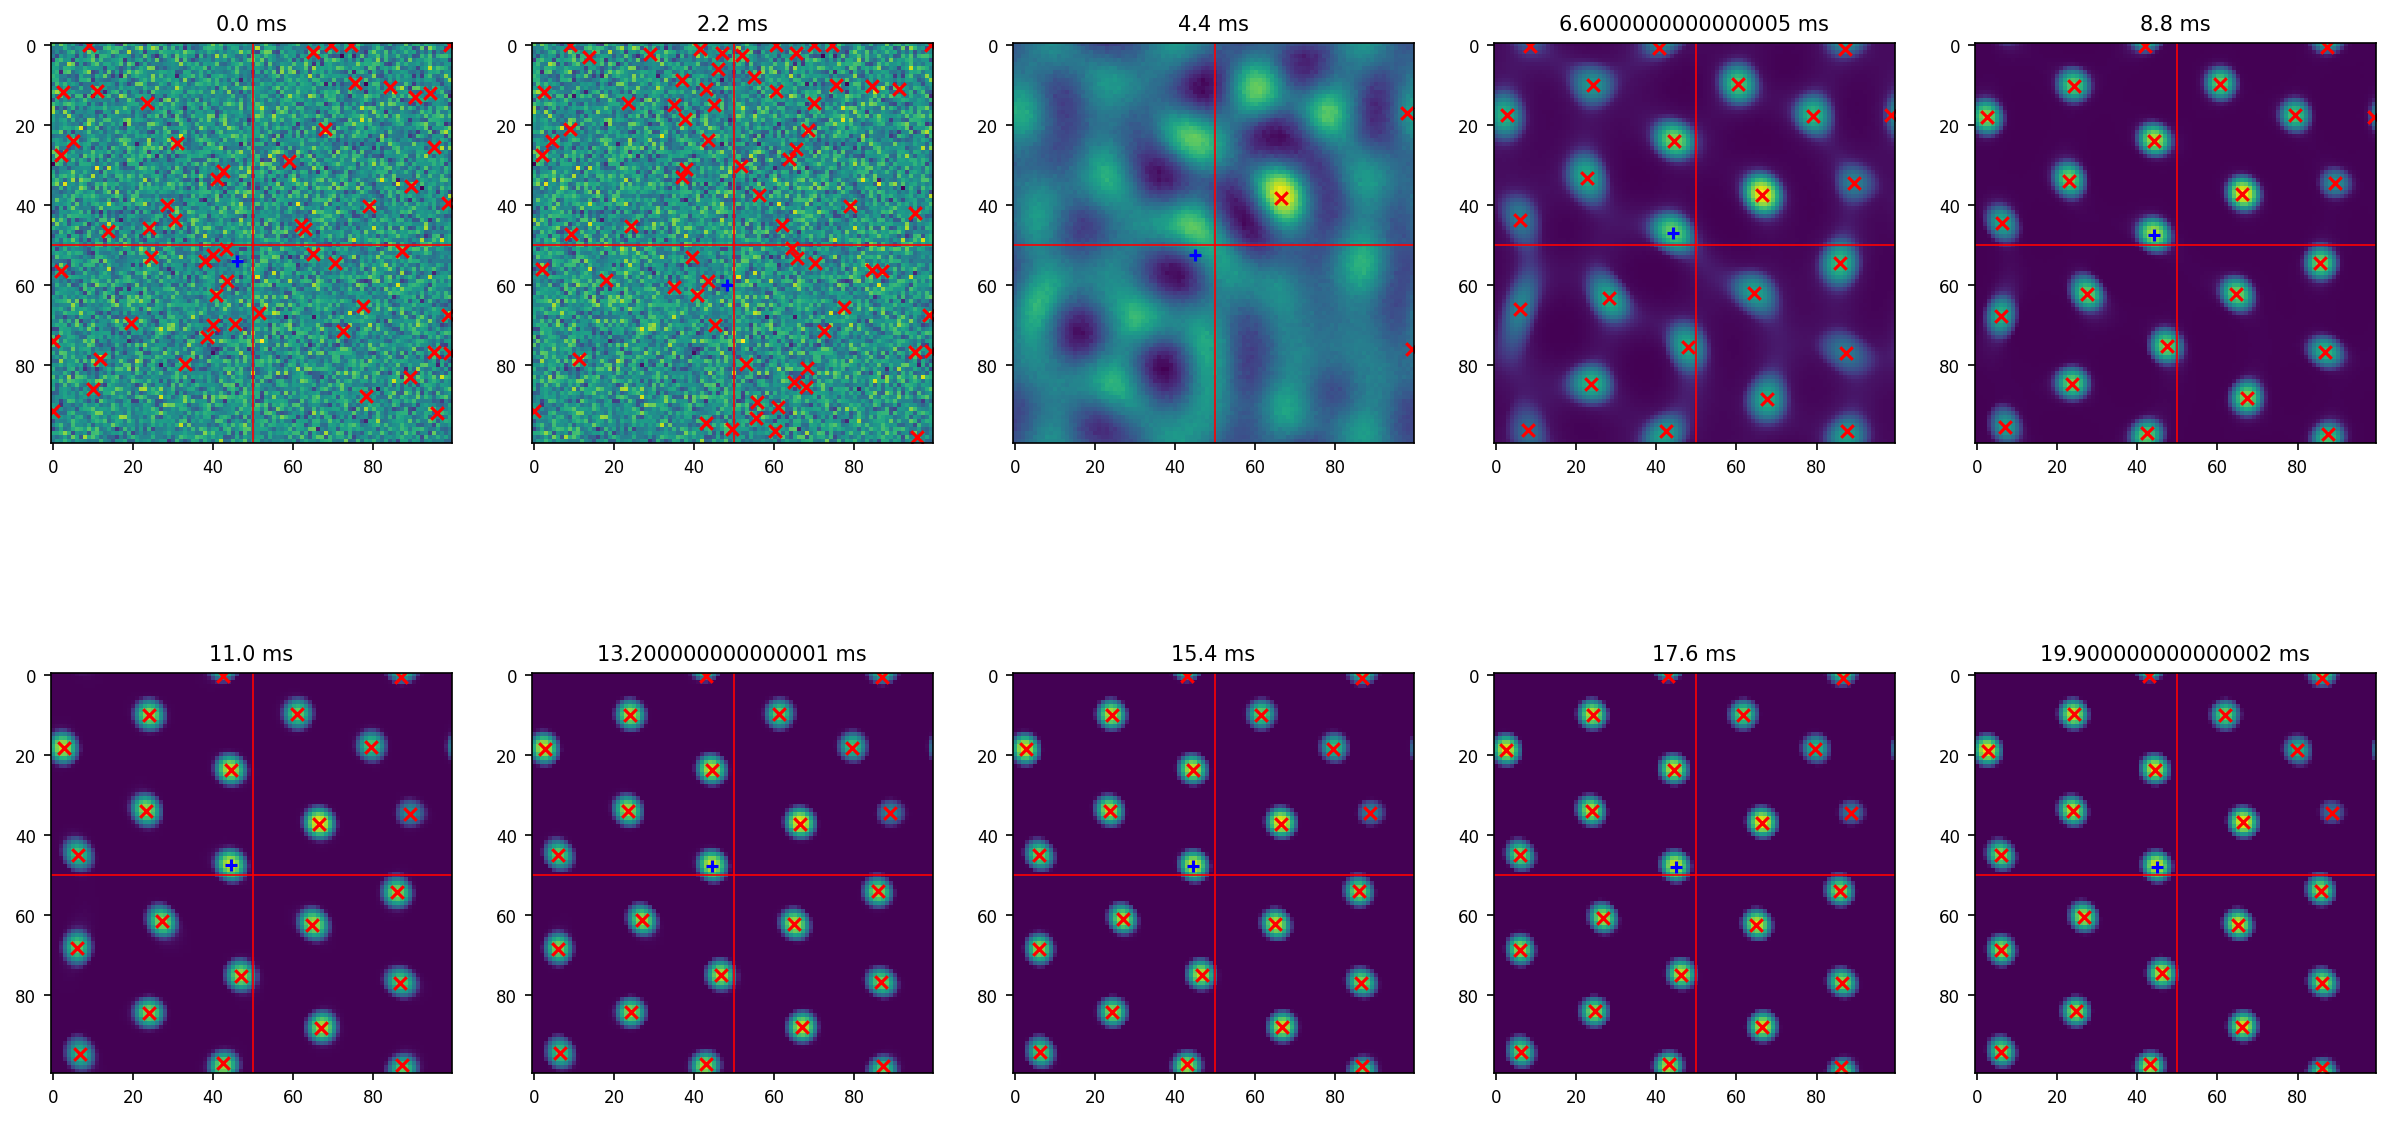

generating movie...


100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


Video recorded at /home/onyxia/work/grid_cells_burak_fiete/figures/pattern_formation.mp4


In [8]:
# uncomment to record pattern formation

"""
T = 0.02
dt = 1e-4
num_steps = int(T/dt)
v = np.zeros((num_steps, 2))
S = grid.simulate(v, s_0 = 0.001*np.random.randn(options.n**2)).squeeze()
plotting.plot_10_frames(S, dt)
plotting.rec_movie(S, fpath=FIG_PATH + 'pattern_formation.mp4', dt=dt, speed_ratio = 1/500)
"""

In [25]:
# uncomment to record pattern moving

T = 0.5
dt = 1e-4
num_steps = int(T/dt)
v = np.zeros((num_steps, 2))
v[:num_steps//2, 0] = 1
v[num_steps//2:, 1] = 1

S = grid.simulate(v).squeeze()

labels = [rf'$v_x =${v[k, 0]}, $v_y=$ {v[k, 1]}' for k in range(len(v))]
plotting.rec_movie(S, fpath=FIG_PATH + 'pattern_moving.mp4', dt=dt, speed_ratio = 1/20, plot_blob_centers=True, frame_labels=labels)


Simulating with Euler method


100%|██████████| 4999/4999 [00:12<00:00, 398.48it/s]


Generating video...


5000it [02:38, 31.53it/s]

Video recorded at /home/onyxia/work/grid_cells_burak_fiete/figures/pattern_moving.mp4


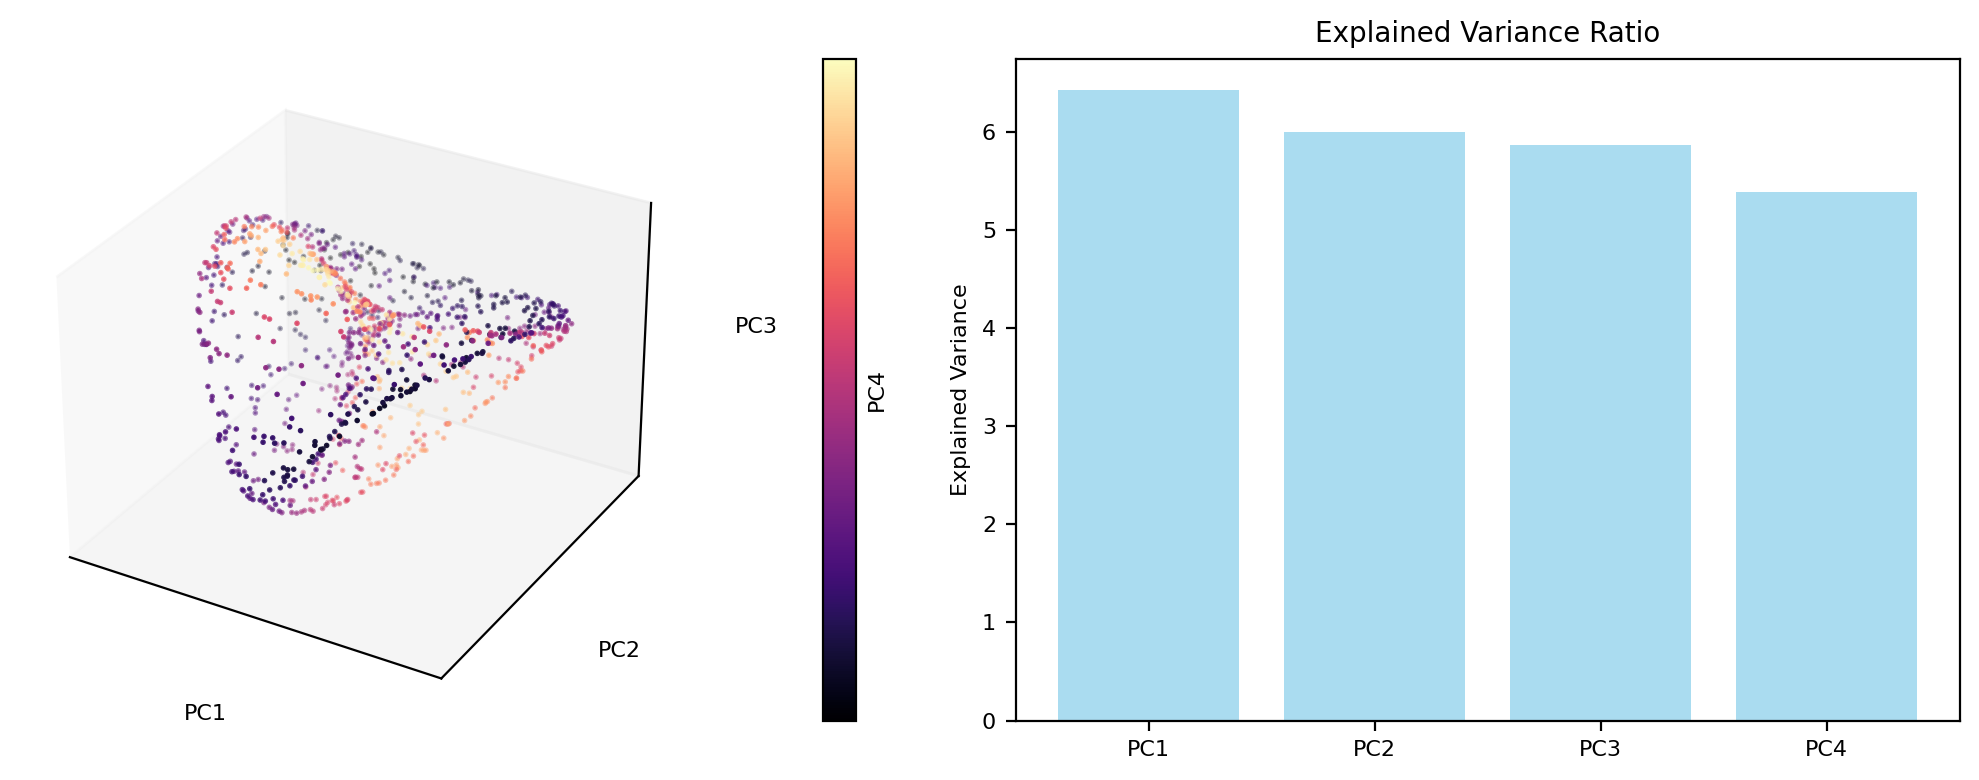

In [10]:
projected_data, explained_variance, components = analysis.pca_torch_gpu(fixed_points.to(options.device), num_components=6)

projected_data = projected_data.cpu().numpy()
fig = plt.figure(figsize=(10, 4), dpi=200)

ax = fig.add_subplot(121, projection='3d')
p = ax.scatter(xs=projected_data[:, 0].astype('float'),
               ys=projected_data[:, 1].astype('float'),
               zs=projected_data[:, 2].astype('float'),
               c=projected_data[:, 3].astype('float'),
               cmap=plt.cm.magma, s=1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

cbar = fig.colorbar(p, ax=ax, pad=0.15, label='PC4')
cbar.set_ticks([])

# Create bar plot for explained variance
ax2 = fig.add_subplot(122)
components = ['PC1', 'PC2', 'PC3', 'PC4']
ax2.bar(components, explained_variance[:4].cpu(), color='skyblue', alpha=0.7)
ax2.set_ylabel('Explained Variance')
#ax2.set_ylim(0, 1)
ax2.set_title('Explained Variance Ratio')

plt.tight_layout()
plt.show()

### 2. Integrate random trajectory

Found pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/trajectory_len=20000_dt=0.0005_w=2.2_h=2.2_rotvelstd=1.6_meanv=0.8_border=0.03_borderslow=0.25.npy, loading it
Simulating with euler method


100%|██████████| 19999/19999 [02:24<00:00, 138.26it/s]


saving simulation at /home/onyxia/work/grid_cells_burak_fiete/sim_data/example_sim_T=10_dt=0.0005_beta=0.013333333333333334_gamma=0.015333333333333332_periodic=True_a=1.5_l=0.5_n=128_tau=0.01_alpha=0.1_tiling=deterministic_device=cuda_solver=euler_dt=0.0005.pth
labeling blobs


100%|██████████| 20000/20000 [00:03<00:00, 6578.11it/s]


detected less than 43 blobs per frame
computing blob centers


/opt/conda/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
100%|██████████| 20000/20000 [00:12<00:00, 1615.52it/s]


found 12 best blob jumps : interpolating speed between them
Estimated prediction to truth size ratio = 0.1223, R2=0.998


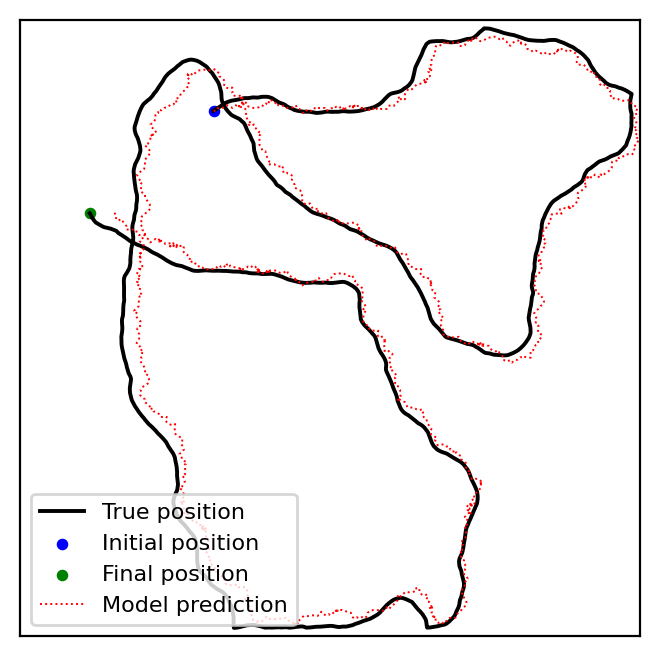

In [30]:
# generate a trajectory 
box_width = box_height = 2.2 # m 
T = 10 # s
dt = grid.options.dt
seq_len = int(T/dt)

traj = generate_trajectory(box_width, box_height, seq_len, dt=dt, load=True, save=True, batch_size = 1, silent=False)
input_v = traj['input_v'].squeeze()
pos = np.stack([traj['target_x'].squeeze(), traj['target_y'].squeeze()], 1)

fname = f"example_sim_T={T}_dt={dt}_{grid.grid_id}.pth"
grid.save_sim = True
S = grid.simulate(input_v, sim_id = fname, silent=False, load=True) # set load = false to restart a new sim from scratch

# downsample if needed for faster analysis 
new_dt = 1E-3
S = utils.downsample(S, new_dt=new_dt, old_dt = dt)
pos = utils.downsample(pos, new_dt=new_dt, old_dt = dt)

pos_pred, prop_factor, r2 = analysis.model_prediction(S, pos, verb = True)

_ = plotting.compare_model_prediction(pos_pred, pos, box_width = box_width, box_height = box_height)

Found pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/trajectory_batchsize=1_len=200000_dt=0.0005_w=2.2_h=2.2_rotvelstd=1.6_meanv=0.8_border=0.03_borderslow=0.25.npy, loading it
loading pre-computed trajectory at /home/onyxia/work/grid_cells_burak_fiete/sim_data/example_sim_T=100_dt=0.0005_beta=0.010380622837370242_gamma=0.011937716262975778_periodic=True_a=1.5_l=2_n=100_tau=0.01_alpha=0.1_tiling=deterministic_device=cuda_solver=euler_dt=0.0005.pth
labeling blobs


100%|██████████| 10000/10000 [00:01<00:00, 8361.82it/s]


detected less than 23 blobs per frame
computing blob centers


/opt/conda/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
100%|██████████| 10000/10000 [00:04<00:00, 2413.75it/s]


found 207 best blob jumps : interpolating speed between them
Estimated prediction to truth size ratio = -0.025, R2=0.998


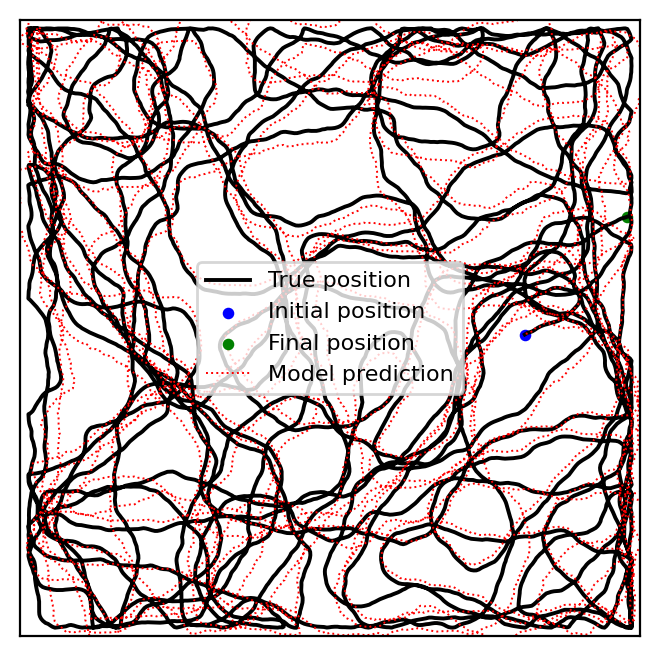

In [4]:
# Collect fixed points : 

box_width = box_height = 2.2 # m 
T = 100 # s
dt = grid.options.dt
seq_len = int(T/dt)

traj = generate_trajectory(box_width, box_height, seq_len, dt=dt, load=True, batch_size = 1, save=True, silent=False)
input_v = traj['input_v'].squeeze()

pos = np.stack([traj['target_x'].squeeze(), traj['target_y'].squeeze()], 1)

grid.save_sim = False

load = True

fname = f"example_sim_T={T}_dt={dt}_{grid.grid_id}.pth"
S = grid.simulate(input_v, sim_id=fname, silent=False, load=load).squeeze() # set load = false to restart a new sim from scratch

if load == False : # otherwise its already downsampled
    new_dt = 1E-2
    S = utils.downsample(S, new_dt=new_dt, old_dt = dt)
    torch.save(S, SIM_PATH + fname)

pos = utils.downsample(pos, new_dt=new_dt, old_dt = dt)
pos_pred, prop_factor, r2 = analysis.model_prediction(S, pos, verb = True)

_ = plotting.compare_model_prediction(pos_pred, pos, box_width = box_width, box_height = box_height)

### 3. Plot grid cell rate map

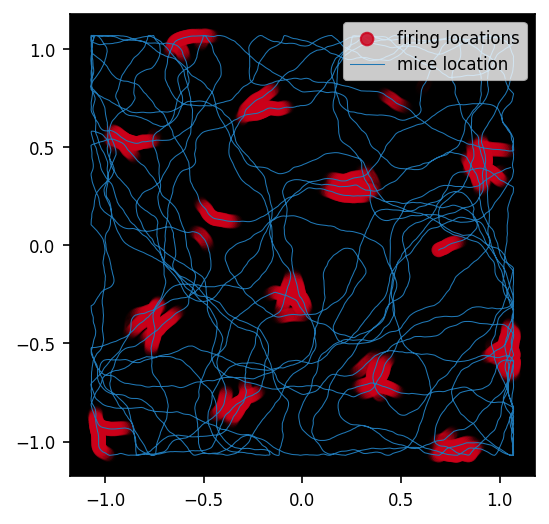

In [5]:
activity = S/S.max()
_ = plotting.plot_rate_over_trajectory(pos, activity, idx=30, show=True, save=True)

### 4. Plot attractor manifold

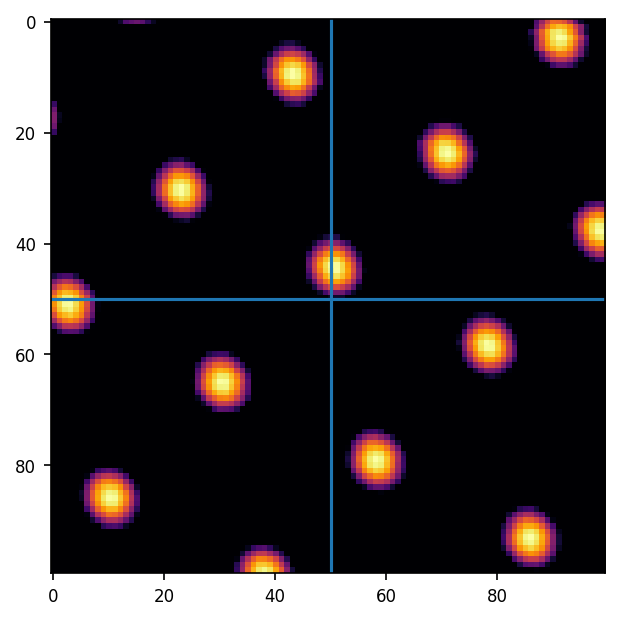

In [159]:
torch.cuda.empty_cache()

fname = 'ratemap_'+grid.grid_id+'.npy'
load = True 
if load :
    ratemap = np.load(EXAMPLE_PATH + fname)

else:
    ratemap = analysis.compute_ratemaps(grid)
    np.save(EXAMPLE_PATH + fname, ratemap)

ratemap=ratemap.transpose(2, 0, 1)

idx = np.random.randint(0, 10000)
plt.imshow(ratemap[idx], cmap = 'inferno')
plt.axvline(50)
plt.axhline(50)

plt.show()

100%|██████████| 10000/10000 [00:05<00:00, 1945.73it/s]


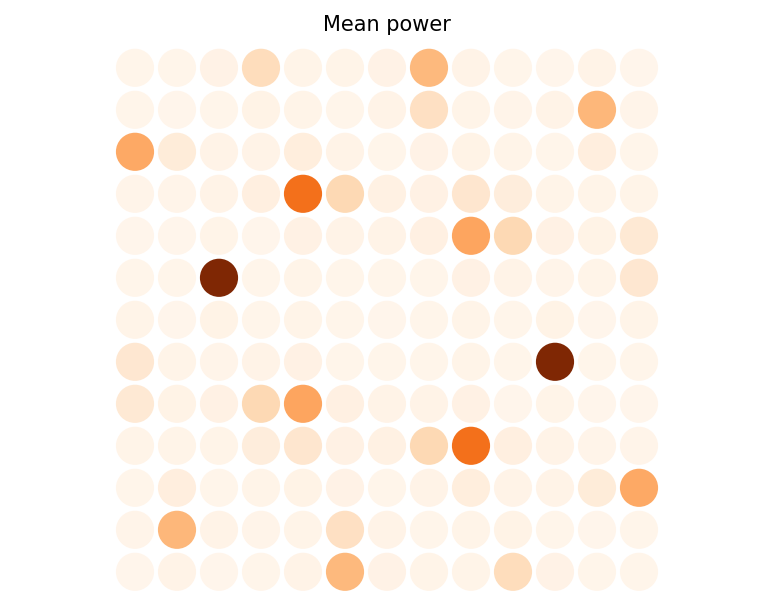

In [19]:
# Fourier transform 

Ng = 10000
res = 100
rm_fft_real = np.zeros([Ng,res,res])
rm_fft_imag = np.zeros([Ng,res,res])

for i in tqdm(range(Ng)):
    rm_fft_real[i] = np.real(np.fft.fft2(ratemap[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(ratemap[i].reshape([res,res])))
    
rm_fft = rm_fft_real + 1j * rm_fft_imag


# Power spectrum




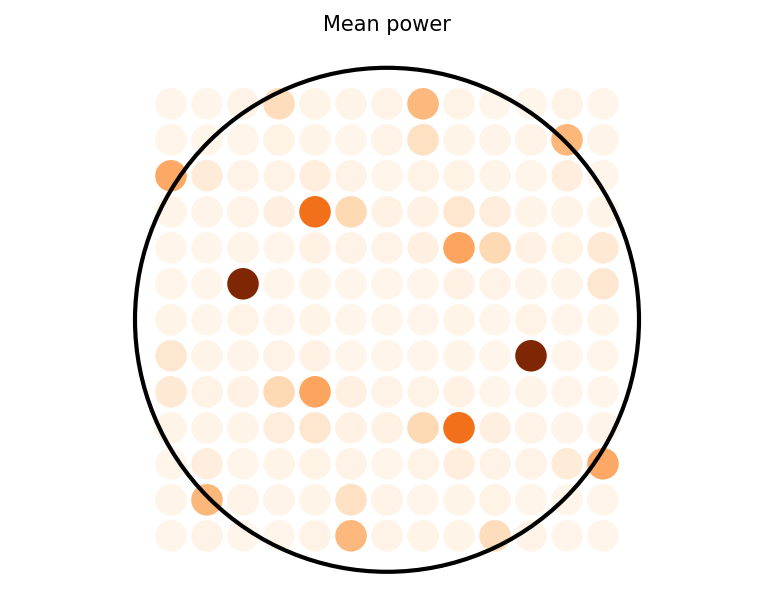

In [82]:
width = 7
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
im = (np.real(rm_fft)**2).mean(0)
im[0,0] = 0

fig, ax =plt.subplots()

ax.scatter(x2,y2,c=im[idxs][:,idxs], s=200, cmap='Oranges', zorder=0)
ax.axis('equal')
ax.axis('off');
ax.set_title('Mean power')
plt.show()

(0.0, 100.0)

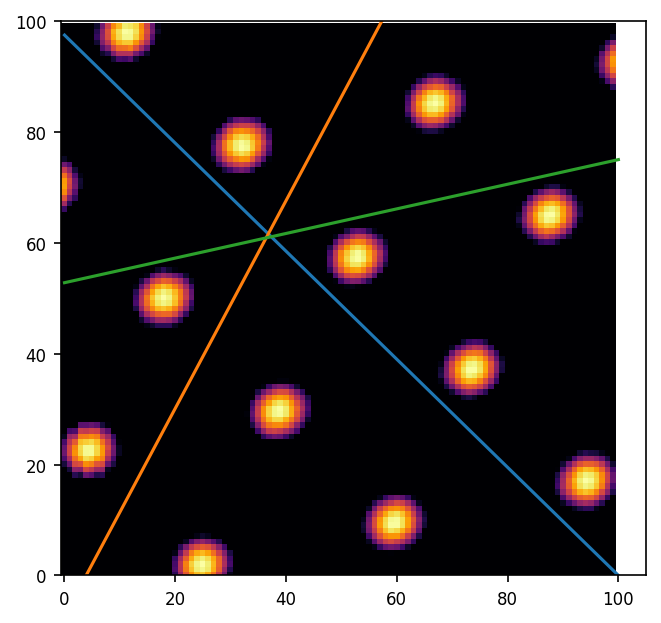

In [132]:
# low frequency directions

k1 = [2,2.05]
k2 = [3,-1.6]
k3 = [-1,4.5]

freq = 1
ks = freq*np.array([k1,k2,k3])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])

x = np.arange(0, 100, 0.1)
orig = 50

plt.imshow(ratemap[30].T, cmap = 'inferno')
plt.plot(100-x, k1[0]/k1[1] * x)
plt.plot(100-x, k2[0]/k2[1] * x+ 180)
plt.plot(100-x, k3[0]/k3[1]* x + 75)
plt.ylim(0, 100)

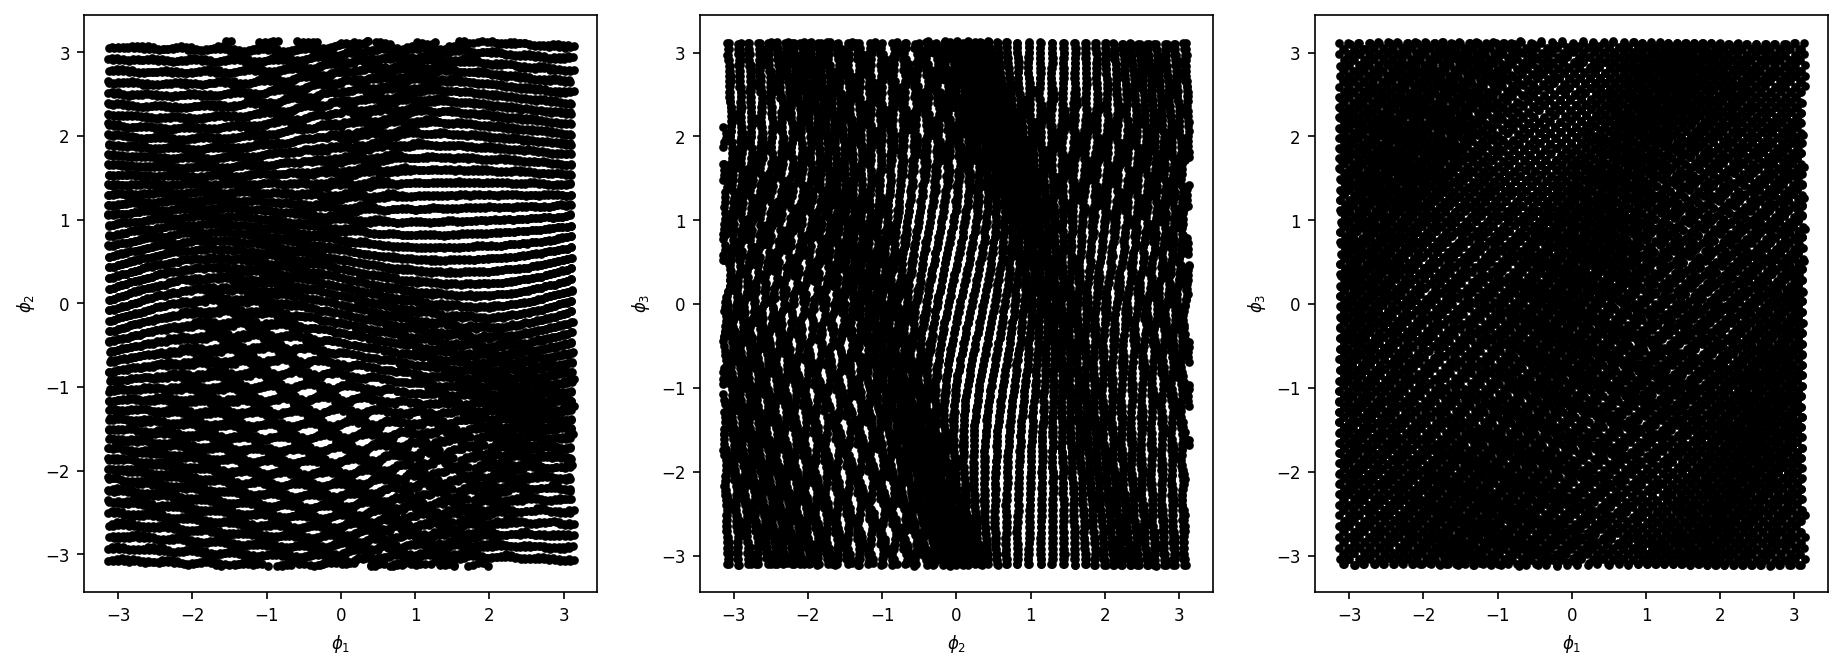

In [133]:
# Find phases
phases = [np.angle(mode) for mode in modes]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phases[0], phases[1], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phases[1], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phases[0], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.show()

Text(0.5, 0, '$\\phi_3$')

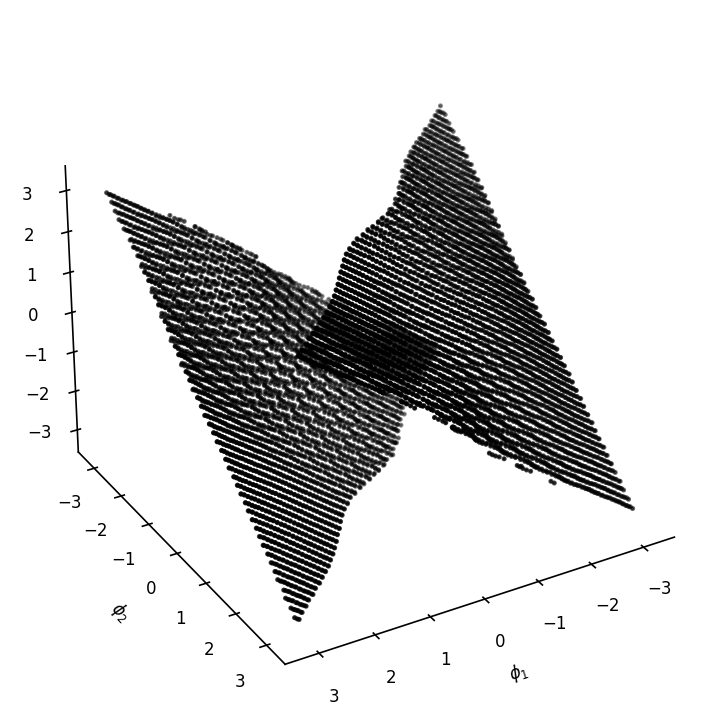

In [134]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(phases[0], phases[1], phases[2], c='black', s=2)
ax.view_init(azim=60)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_zlabel(r'$\phi_3$')

In [193]:
np.linalg.norm(B, axis=1)

array([70.71212832, 70.70922788])

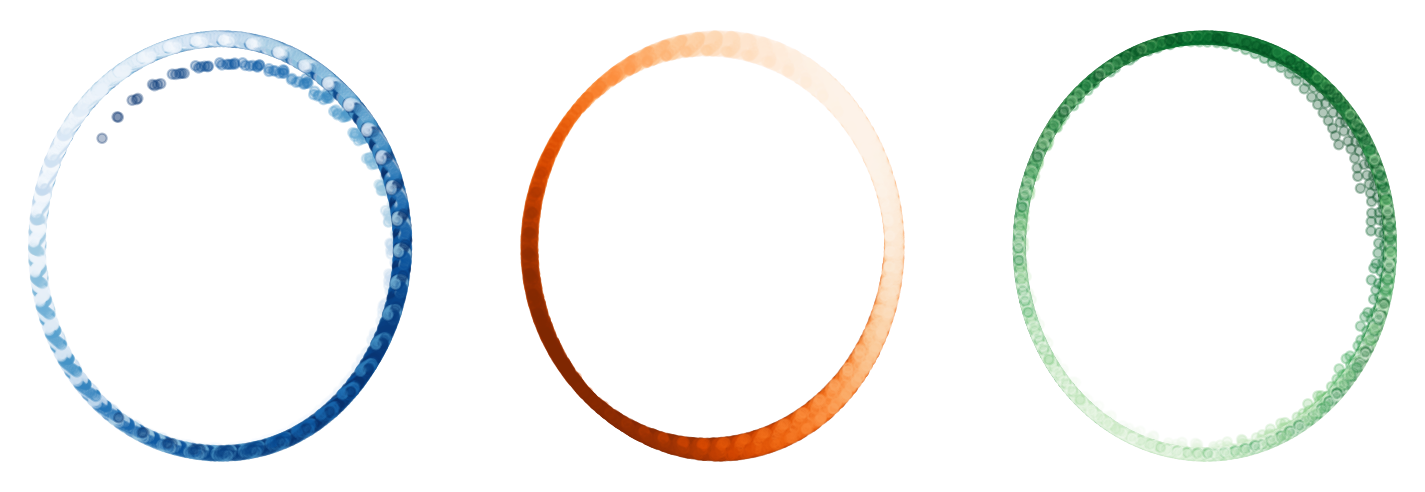

In [201]:
freq = 1
crop = 0
cmaps = ['Blues', 'Oranges', 'Greens']
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()
all_axis = []
plt.figure(figsize=(12,4))
all_tests = []
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@ratemap.reshape(-1, res**2)/np.linalg.norm(B, axis=1, keepdims=True)
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20, alpha=0.3)
    all_axis.append(B)
    all_tests.append(test[0])
    all_tests.append(test[1])
    plt.axis('off')

all_tests = np.stack(all_tests)
all_axis = np.concatenate(all_axis)

plt.savefig(FIG_PATH + "phases.png", transparent=True)


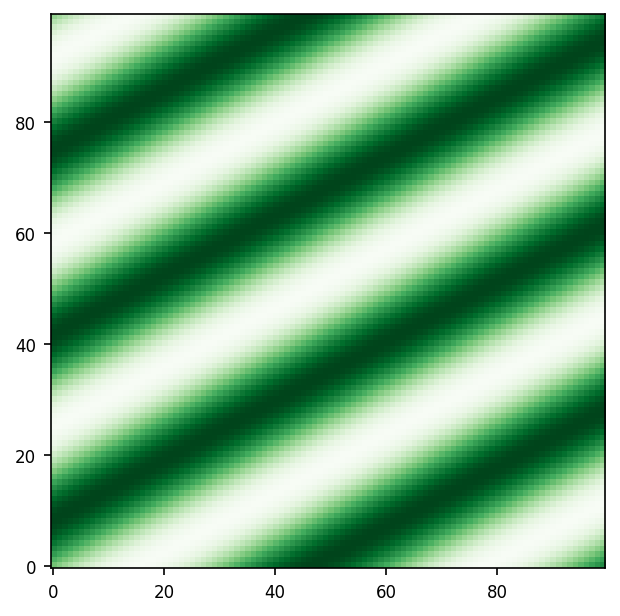

In [184]:
plt.imshow(X[4].reshape(100, 100), origin='lower',cmap = 'Greens')

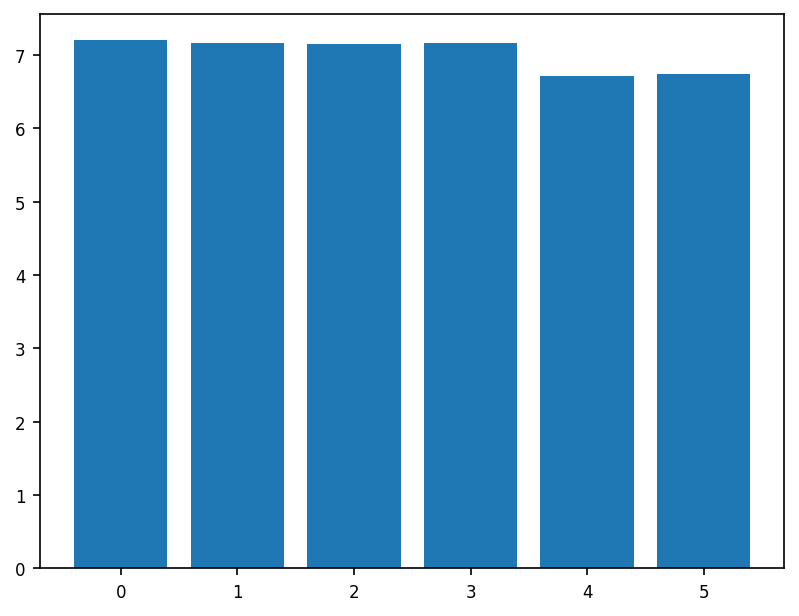

In [207]:
# variance explained

fig, ax = plt.subplots()
axvars = all_tests.var(axis=1)
tot_var = ratemap.reshape(10000, 10000).var(1).sum()
plt.bar([k for k in range(6)], list(100*axvars/tot_var))
plt.show()

Text(0.5, 0, '$\\phi_3$')

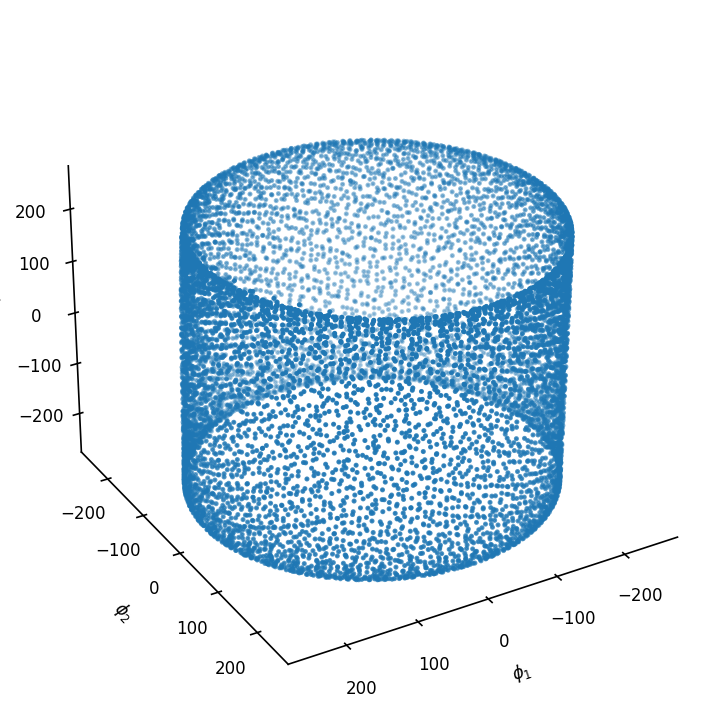

In [138]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
cmaps ='Purples'
ax.scatter(all_tests[0], all_tests[1], all_tests[2], s=2)
ax.view_init(azim=60)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_zlabel(r'$\phi_3$')

### 3. Normativity and optimisation : Train a RNN

We re-exploited recent work from [Sorscher *et al.* 2023](https://doi.org/10.1080/02786828708959166)

We adapted part of their [original code](https://github.com/ganguli-lab/grid-pattern-formation) for our simple use. In particular, grid cells patterns of activation were changed and new constraints were imposed to the model

In [46]:
rnn_opt = RNN_options()

rnn_opt.save_dir = os.getcwd() + '/models/'
rnn_opt.n_steps = 10000         # number of training steps
rnn_opt.batch_size = 200         # number of trajectories per batch
rnn_opt.sequence_length = 100     # number of steps in trajectory
rnn_opt.learning_rate = 1e-4     # gradient descent learning rate
rnn_opt.pc_sheet_size = 30      # sqrt of number of place cells 
rnn_opt.gc_sheet_size = 40       # sqrt of number of grid cells
rnn_opt.pc_sigma = 0.2

# width of place cell center tuning curve (m)
rnn_opt.activation = 'relu'      # recurrent nonlinearity
rnn_opt.weight_decay = 1e-4      # strength of weight decay on recurrent weights
rnn_opt.box_width = 2.2            # width of square arena 
rnn_opt.dt = 1E-2
rnn_opt.device = "cuda" if torch.cuda.is_available() else 'cpu'
rnn_opt.optim = 'adam'
rnn_opt.clip_grad = False
rnn_opt.debug = False

network = TrainableNetwork(rnn_opt,)
trainer = Trainer(network,  restore=True)

Restored trained model from /home/onyxia/work/grid_cells_burak_fiete/models/n_steps_10000_batch_size_200_sequence_length_100_learning_rate_0.0001_pc_sheet_size_30_gc_sheet_size_40_pc_sigma_0.2_activation_relu_weight_decay_0.0001_box_width_2.2_dt_0.01_optimizer_adam_device_cuda_clip_grad_False_optim_adam/most_recent_model.pth


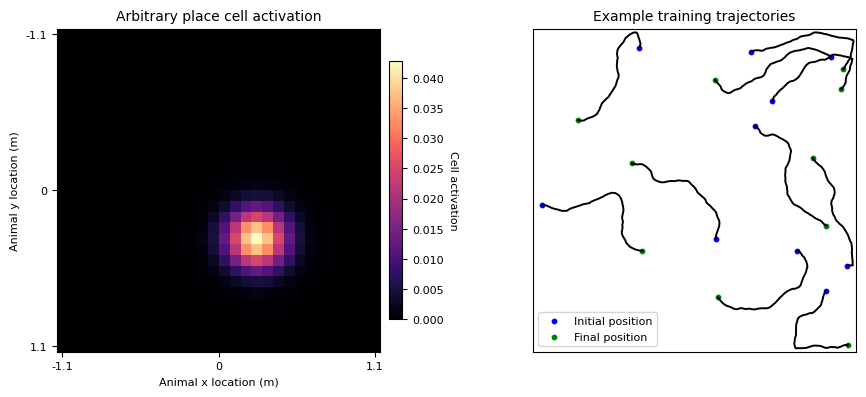

In [51]:
_ = plotting.present_training_environment(network, trainer, show=True)

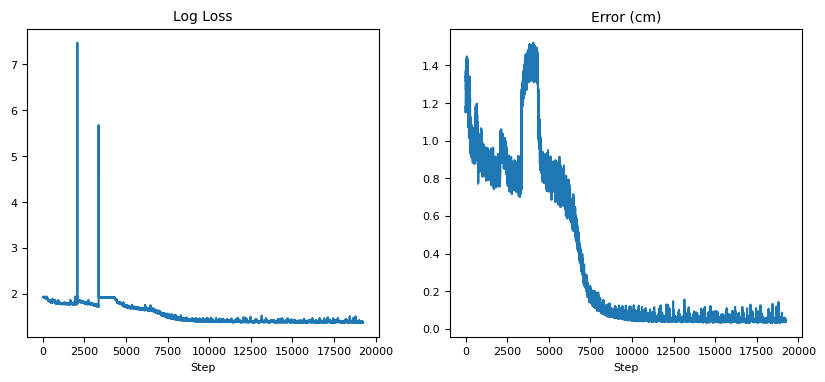

Epoch 1/2 step 9278 : Loss 3.96 Error =   3.5 cm:  93%|█████████▎| 9279/10000 [33:37<03:02,  3.94it/s]

In [ ]:
n_epochs = 2
# trainer.train(n_epochs, rnn_opt.n_steps, plot=True)

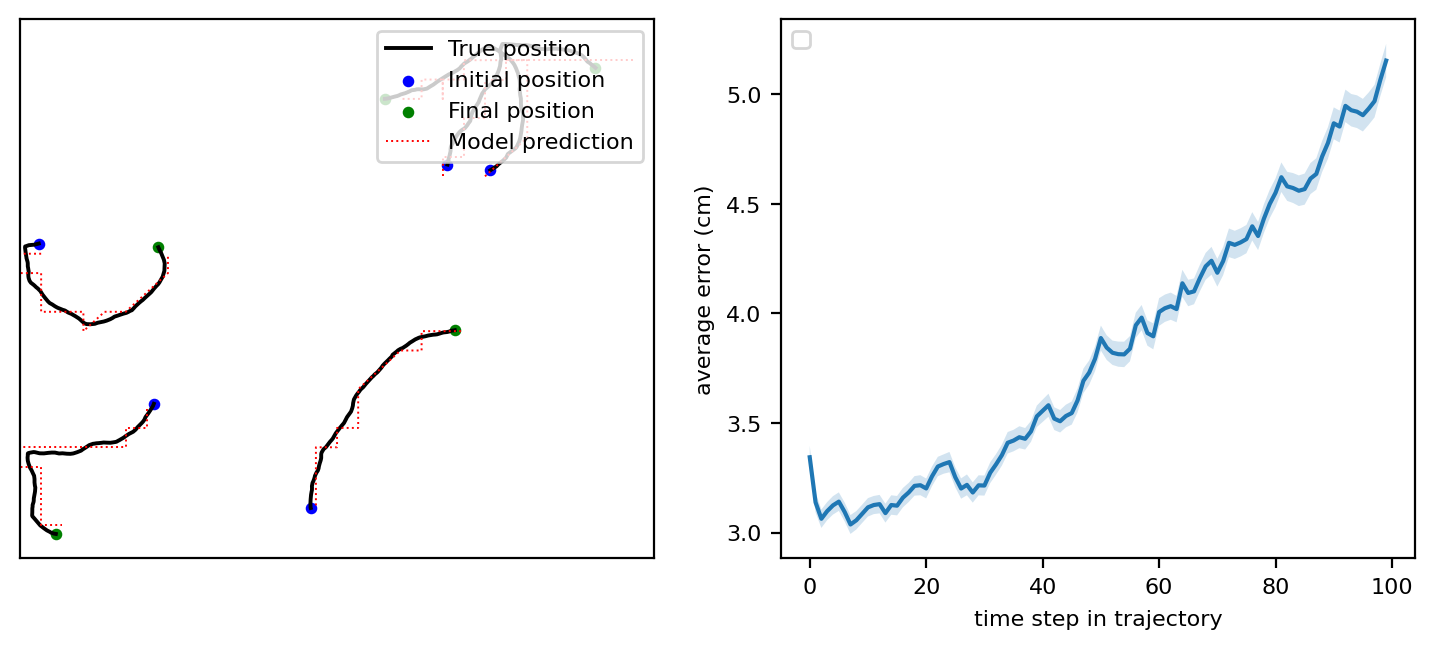

In [13]:
_ = plotting.show_training_results(trainer, network, sequence_length = 100, num_trajectories =1000, plotted_trajectories=5, show=True)

In [14]:
model_name = f"example_weight_decay={rnn_opt.weight_decay}_pc={rnn_opt.pc_sheet_size**2}_gc={rnn_opt.pc_sheet_size**2}_seqlen={rnn_opt.sequence_length}_no_other_reg.pth"

torch.save(network.state_dict(), EXAMPLE_PATH + model_name)

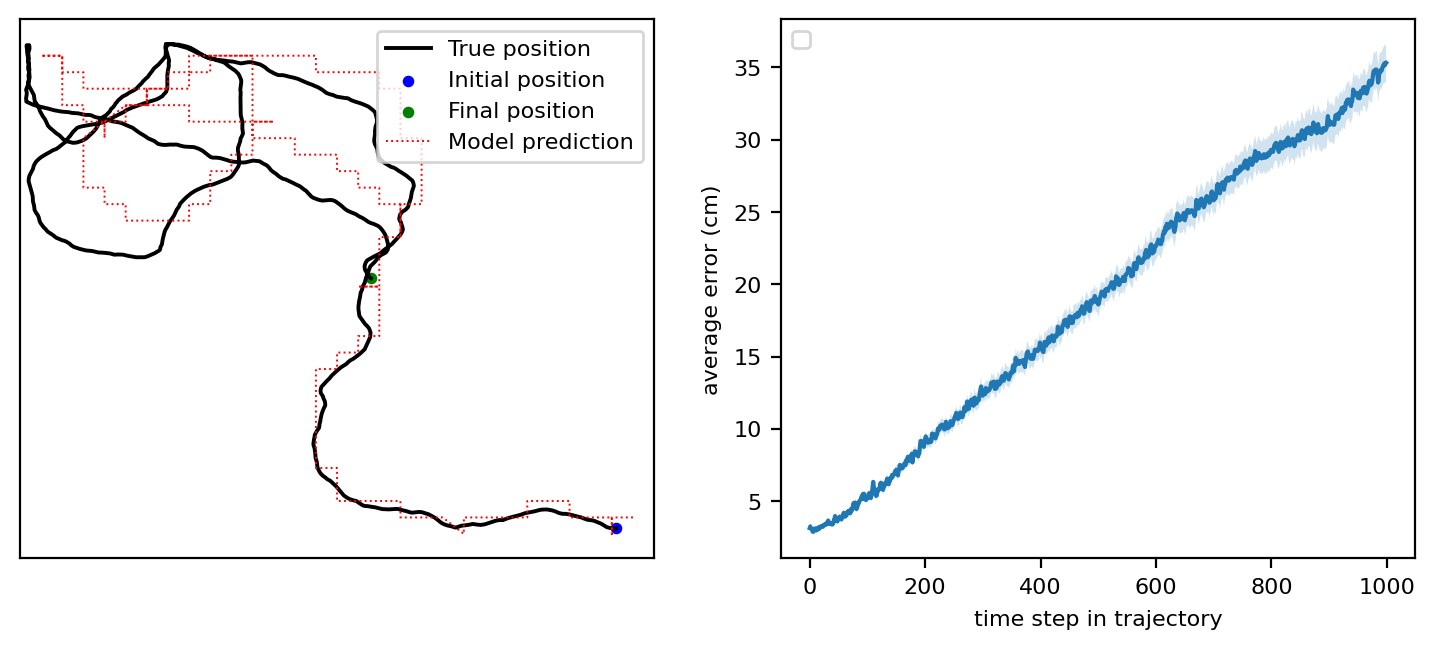

In [15]:
_ = plotting.show_training_results(trainer, network, show=True, sequence_length = 1000, plotted_trajectories = 1, num_trajectories = 100)

## 4. Evaluate performances of both approaches

In [ ]:
plt.plot(W_grid

# TODO :

### 1) Résultats principaux de l'article ->> Nicolas
- Faire une fonction qui montre le champ d'activation d'une grid cell, pour voir si l'activation est effectivement en grille
- Evaluer comment les erreurs se propagent au cours du temps cf figure 2 de l'article

### 2) RNN ->> Grégoire
- Voire si on peut améliorer la résolution spatiale des place cells
- Voire si on peut augmenter la taille de la séquence ( très courte pour l'instant et tester le modèle sur une grosse séquence )
- Utiliser les fonctions du **1)** pour evaluer le RNN - > comparer les modèles
- Ajouter des contraintes supplémentaires (contraintes sur l'activité "energetiques" en plus des contraintes sur les poids

### 3) Possibles suites
- Projection de l'activité des cellules dans un espace a faible dimension pour les deux réseaux -> voire les projections présentées dans la littérature
- Comparaison de la connectivité des cellules entre RNN et Burak-> Grégoire se renseigne la dessus
- Ondes theta et phase precession -> Nicolas si il a le temps

#### Avec ca on est très large en terme de contenu, largement au dessus des attentes du cours a mon avis ;)